# <span style = 'color: red'>**Práctica dos.** Aprendizaje de máquina. *Redes neuronales*</span>

# ***Parte dos.*** **Series de tiempo con RNN y LSTM.**

## **Simón Cuartas Rendón**

En este *notebook* de Python se aborda el desarrollo del **segundo problema** de la *práctica dos* del curso de **Aprendizaje de Máquina**.

A continuación, se abren los paquetes que se usarán para dar solución al problema propuesto.

**Anotación.** Este *notebook* está disponible en línea para facilitar su revisión. Se puede acceder al repositorio de GitHub [aquí](https://github.com/scuartasr/aprendmaq_entregable_2/tree/main), y en particular, a este cuaderno [aquí](https://github.com/scuartasr/aprendmaq_entregable_2/blob/main/Cuadernos/02_rnn_lstm_apple.ipynb).

In [1]:
#
# Apertura de paquetes generales relevantes
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Apertura de paquetes para el trabajo con RNN
import tensorflow as tf
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

# Otras librerías analíticas
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error,
)
from sklearn.preprocessing import MinMaxScaler

# Otras librerías
import pydot
from keras.utils import plot_model

## <span style = 'color: cyan'>***2.1.***</span> Apertura del marco de datos y revisión inicial

Se realizará la lectura de los datos. A continuación, se observarán los primeros y últimos registros de los datos de entrenamiento, así como los primeros cinco registros del conjunto de validación.

In [2]:
#
# Apertura de datos

# Entrenamiento
direc_entr = '../Datos/AAPL/AAPL.xls'
aapl_entr = pd.read_csv(direc_entr)

# Out of time
direc_out = '../Datos/AAPL/AAPL - Jan2018.xls'
aapl_out = pd.read_csv(direc_out)

# Dimensiones
print(
    f'Los datos de entrenamiento tienen {aapl_entr.shape[0]} filas y {aapl_entr.shape[1]} columnas.',
    f'Los datos de validación tienen {aapl_out.shape[0]} filas y {aapl_out.shape[1]} columnas.',
    sep='\n'
)

Los datos de entrenamiento tienen 1259 filas y 2 columnas.
Los datos de validación tienen 20 filas y 2 columnas.


In [3]:
#
# Visualización de las primeras filas
pd.concat([aapl_entr.head(), aapl_entr.tail()], axis=0, ignore_index=True)

,Date,Open
0,1/2/2013,79.117142
1,1/3/2013,78.268570
2,1/4/2013,76.709999
3,1/7/2013,74.571426
4,1/8/2013,75.601425
5,12/22/2017,174.679993
6,12/26/2017,170.800003
7,12/27/2017,170.100006
8,12/28/2017,171.000000
9,12/29/2017,170.520004


In [4]:
#
# Visualización de las primeras filas
aapl_out.head()

,Date,Open
0,1/2/2018,170.160004
1,1/3/2018,172.529999
2,1/4/2018,172.539993
3,1/5/2018,173.440002
4,1/8/2018,174.350006


Como se puede observar, se tienen dos tablas con estructura idéntica:
- Se tiene la columna `Date`, con la cual se expone la fecha de cada observación.
- Se tiene la columan `Open`, que registra el precio de apertura de la especie $\text{AAPL}$ en la bolsa de valores Nasqad. Esta expresado en dólares estadounidenses ($\text{USD}$).

El conjunto de entrenamiento congrega $1,259$ registros que inician el 2 de enero de 2013 y llegan hasta el 29 de diciembre de 2017. Por su parte, con la base de validación se tienen registros para todos los días hábiles del mes de enero del 2018.

Ahora, observando la tipología de dato para cada conjunto:

In [5]:
#
# Información del conjunto de entrenamiento
aapl_entr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1259 non-null   object 
 1   Open    1259 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.8+ KB


In [6]:
#
# Información del conjunto de validación
aapl_out.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 448.0+ bytes


Se observa que en ambos conjuntos la información del precio de apertura de la acción es correcta, pero no es el caso para el campo de la fecha. Así, se procederá con su transformación.

In [7]:
#
# Transformación de la fecha
aapl_entr['Date'] = pd.to_datetime(aapl_entr['Date'], format='%m/%d/%Y')
aapl_out['Date'] = pd.to_datetime(aapl_out['Date'], format='%m/%d/%Y')

# Un ejemplo
aapl_entr.head()

,Date,Open
0,2013-01-02,79.117142
1,2013-01-03,78.268570
2,2013-01-04,76.709999
3,2013-01-07,74.571426
4,2013-01-08,75.601425


## <span style = 'color: cyan'>***2.2.***</span> Visualización

A continuación, se presenta la serie temporal.

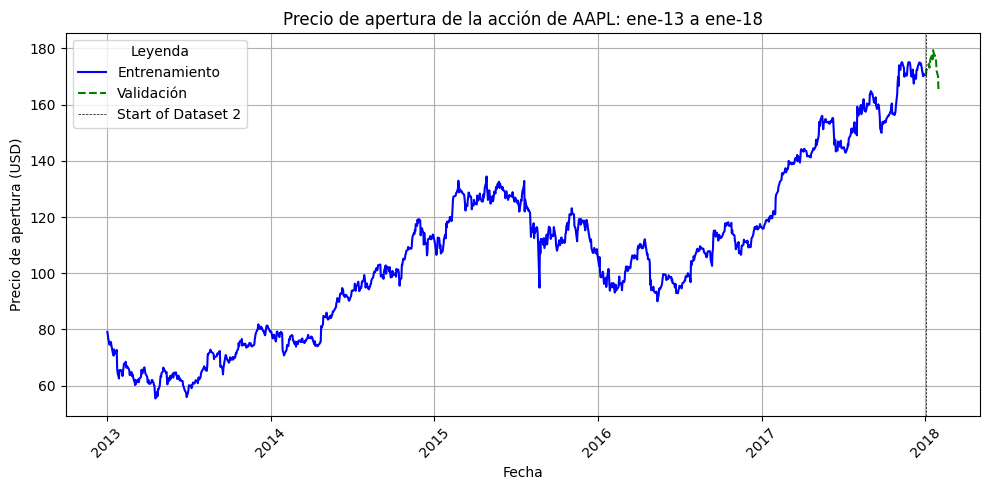

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(aapl_entr['Date'], aapl_entr['Open'], label='Entrenamiento', color='blue', linewidth=1.5, )
plt.plot(aapl_out['Date'], aapl_out['Open'], label='Validación', color='green', linestyle='--', linewidth=1.5, )
plt.axvline(x=aapl_out['Date'].min(), color='black', linestyle='--', linewidth=0.5, label='Start of Dataset 2')
plt.title('Precio de apertura de la acción de AAPL: ene-13 a ene-18')
plt.xlabel('Fecha')
plt.ylabel('Precio de apertura (USD)')
plt.xticks(rotation=45)
plt.legend(title='Leyenda')
plt.grid()
plt.tight_layout()
plt.show()

## <span style = 'color: cyan'>***2.3.***</span> Normalización de los datos

De cara a facilitar el procesamiento y ajuste de la red, se van a normalizar los datos.

In [9]:
#
# Objeto de escalamiento
scaler = MinMaxScaler()

# Escalado de los datos
aapl_entr['open_esc'] = scaler.fit_transform(aapl_entr[['Open']])
aapl_out['open_esc'] = scaler.transform(aapl_out[['Open']])

In [10]:
#
# Revisión de los primeros cinco registros
aapl_entr.head()

,Date,Open,open_esc
0,2013-01-02,79.117142,0.197959
1,2013-01-03,78.268570,0.190869
2,2013-01-04,76.709999,0.177847
3,2013-01-07,74.571426,0.159978
4,2013-01-08,75.601425,0.168584


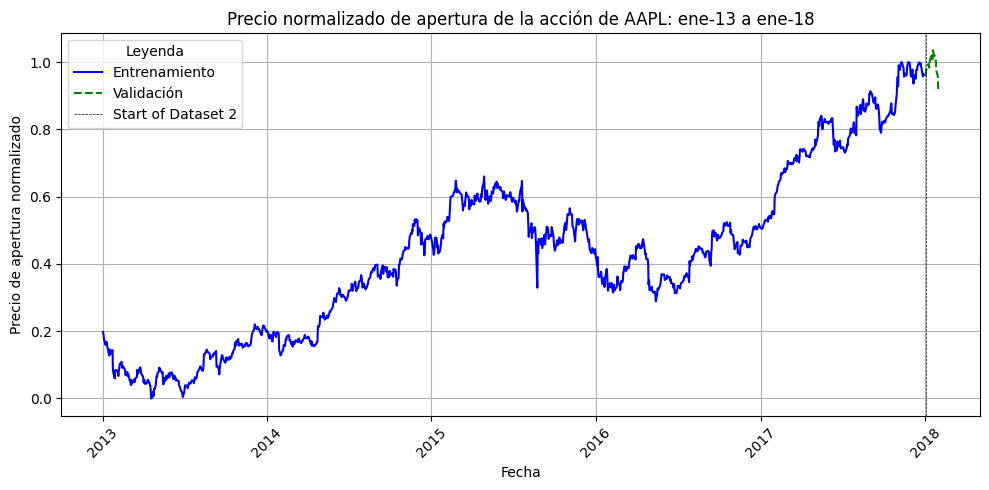

In [11]:
plt.figure(figsize=(10, 5))
plt.plot(aapl_entr['Date'], aapl_entr['open_esc'], label='Entrenamiento', color='blue', linewidth=1.5, )
plt.plot(aapl_out['Date'], aapl_out['open_esc'], label='Validación', color='green', linestyle='--', linewidth=1.5, )
plt.axvline(x=aapl_out['Date'].min(), color='black', linestyle='--', linewidth=0.5, label='Start of Dataset 2')
plt.title('Precio normalizado de apertura de la acción de AAPL: ene-13 a ene-18')
plt.xlabel('Fecha')
plt.ylabel('Precio de apertura normalizado')
plt.xticks(rotation=45)
plt.legend(title='Leyenda')
plt.grid()
plt.tight_layout()
plt.show()

Nótese que existen registros con valores mayores que uno en el periodo de validación. Esto sucede porque en ese conjunto de datos existe máximos históricos que no fueron observados durante el periodo de entrenamiento. Sin embargo, esto no debe suponer ningún impacto en el ajuste del modelo.

## <span style = 'color: cyan'>***2.4.***</span> Estructuración del marco de datos

Se va a llevar el marco de datos a un formato adecuado para el entrenamiento de modelos de redes neuronales para series de tiempo.

In [12]:
#
# Método para construir los conjuntos X e y para entrenamiento y validación
def get_XY(dat, time_steps):
    # Indices del arreglo Y
    Y_ind = np.arange(time_steps, len(dat), time_steps)
    # Arreglo de los valores a estimar
    Y = dat[Y_ind]
    # Organización de X en un arreglo de
    # total_samples x time_steps x features
    rows_x = len(Y)
    X = dat[range(time_steps * rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))
    Y = np.reshape(Y, (-1, 1))
    return X, Y

In [13]:
#
time_steps = 3

# Aplicación a entrenamiento
X_entr, y_entr = get_XY(aapl_entr['open_esc'].values, time_steps)

# Aplicación a validación
X_out, y_out = get_XY(aapl_out['open_esc'].values, time_steps)

Ahora, se observarán las dimensiones:

In [14]:
#
# Dimensiones en entrenamiento
print(
    'DATOS DE ENTRAMIENTO:',
    f'\nX: {X_entr.shape}',
    f'\ny: {y_entr.shape}',
    '-',
    '-',
    'DATOS DE VALIDACIÓN:',
    f'\nX: {X_out.shape}',
    f'\ny: {y_out.shape}',
    sep='\n'
)

DATOS DE ENTRAMIENTO:

X: (419, 3, 1)

y: (419, 1)
-
-
DATOS DE VALIDACIÓN:

X: (6, 3, 1)

y: (6, 1)


## <span style = 'color: cyan'>***2.5.***</span> Primera estructura de prueba

### <span style = 'color: green'>***2.5.1.***</span> Configuración del modelo

Ahora, se va a probar una estructura de prueba inicial siguiendo la configuración que se realizó en clase.

In [15]:
#
# Configuración del modelo

modelo_1 = Sequential()
modelo_1.add(SimpleRNN(3, input_shape=(time_steps, 1), activation='tanh', return_sequences=True, ))
modelo_1.add(SimpleRNN(1, ))

/Users/scuartasr/Documents/Maestría/aprenmaq/entreg2/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
modelo_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 3, 3)           │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

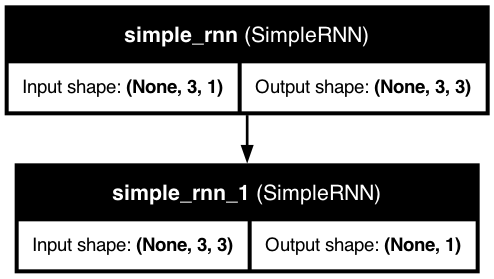

In [17]:
plot_model(
    modelo_1,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96
)

### <span style = 'color: green'>***2.5.2.***</span> Entrenamiento del modelo

In [18]:
#
# Parámetros para la optimización del modelo
modelo_1.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error', ], 
)

#
# Entrenamiento del modelo
historia_1 = modelo_1.fit(
    X_entr,
    y_entr,
    epochs=100,
    batch_size=32,
    verbose=1,
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1649 - mean_absolute_error: 0.3445 - mean_squared_error: 0.1649  
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0935 - mean_absolute_error: 0.2449 - mean_squared_error: 0.0935
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0504 - mean_absolute_error: 0.1772 - mean_squared_error: 0.0504
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0344 - mean_absolute_error: 0.1446 - mean_squared_error: 0.0344
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0279 - mean_absolute_error: 0.1311 - mean_squared_error: 0.0279
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0269 - mean_absolute_error: 0.1309 - mean_squared_error: 0.0269
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0255 - mean_absolute_error: 0.1264 - mean_squared_error: 0.0255
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0237 - mean_absolute_error: 0.1218 - mean_squared_error: 0.023

### <span style = 'color: green'>***2.5.3.***</span> Predicciones con el modelo

In [19]:
def metricas_modelo(modelo, X_tr, X_ts, y_tr, y_ts, scaler=scaler):
    # Predicciones
    y_tr_pred = modelo.predict(X_tr)
    y_ts_pred = modelo.predict(X_ts)

    # Asegurar forma adecuada
    y_tr = y_tr.reshape(-1, 1)
    y_ts = y_ts.reshape(-1, 1)
    y_tr_pred = y_tr_pred.reshape(-1, 1)
    y_ts_pred = y_ts_pred.reshape(-1, 1)

    # Invertir normalización
    y_tr_inv = scaler.inverse_transform(y_tr)
    y_ts_inv = scaler.inverse_transform(y_ts)
    y_tr_pred_inv = scaler.inverse_transform(y_tr_pred)
    y_ts_pred_inv = scaler.inverse_transform(y_ts_pred)

    # Métricas
    mse_tr = mean_squared_error(y_tr_inv, y_tr_pred_inv)
    mse_ts = mean_squared_error(y_ts_inv, y_ts_pred_inv)

    mae_tr = mean_absolute_error(y_tr_inv, y_tr_pred_inv)
    mae_ts = mean_absolute_error(y_ts_inv, y_ts_pred_inv)

    r2_tr = r2_score(y_tr_inv, y_tr_pred_inv)
    r2_ts = r2_score(y_ts_inv, y_ts_pred_inv)

    mape_tr = mean_absolute_percentage_error(y_tr_inv, y_tr_pred_inv)
    mape_ts = mean_absolute_percentage_error(y_ts_inv, y_ts_pred_inv)

    print(
        '>>> MÉTRICAS DEL MODELO <<<',
        ' ',
        'DATOS DE ENTRENAMIENTO:',
        f'\nMSE: {mse_tr:.4f}',
        f'\nRMSE: {np.sqrt(mse_tr):.4f}',
        f'\nMAE: {mae_tr:.4f}',
        f'\nMAPE: {mape_tr:.4f}',
        f'\nR2: {r2_tr:.4f}',
        ' ',
        'DATOS DE VALIDACIÓN:',
        f'\nMSE: {mse_ts:.4f}',
        f'\nRMSE: {np.sqrt(mse_ts):.4f}',
        f'\nMAE: {mae_ts:.4f}',
        f'\nMAPE: {mape_ts:.4f}',
        f'\nR2: {r2_ts:.4f}',
        sep='\n'
    )


In [20]:
#
# Métricas del modelo
metricas_modelo(modelo_1, X_entr, X_out, y_entr, y_out)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>>> MÉTRICAS DEL MODELO <<<
 
DATOS DE ENTRENAMIENTO:

MSE: 40.0478

RMSE: 6.3283

MAE: 4.5370

MAPE: 0.0413

R2: 0.9543
 
DATOS DE VALIDACIÓN:

MSE: 562.0541

RMSE: 23.7077

MAE: 23.5405

MAPE: 0.1342

R2: -59.5398


### <span style = 'color: green'>***2.5.4.***</span> Visualización del resultado

In [21]:
# Plot the result
def plot_result(trainY, testY, train_predict, test_predict, model):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=80)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Observado', 'Pronóstico'])
    plt.xlabel('Número de observación después de un paso de tiempo (\'time step\') dado')
    plt.ylabel('Precio de apertura (USD)')
    plt.title(f'Precio de apertura de AAPL: entrenamiento y validación - {model}')
    plt.grid()
    plt.show()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


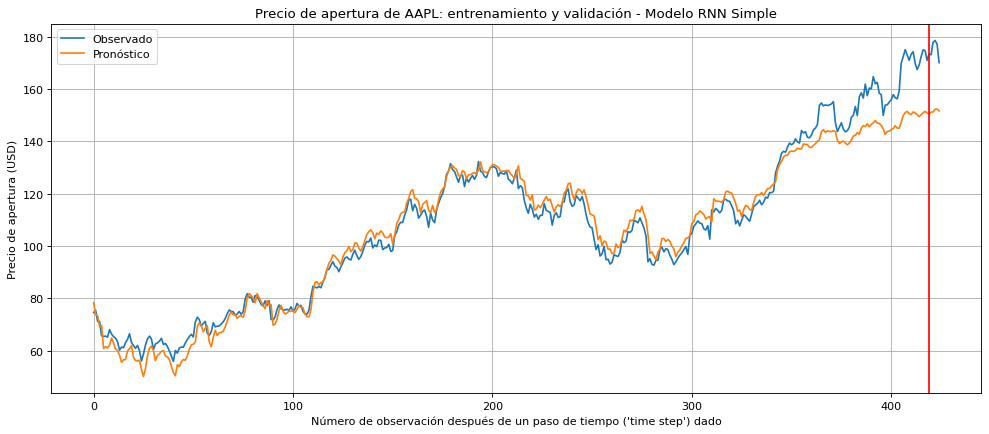

In [22]:
#
# Pronósticos en términos de la escala real de la acción
y_entr_inv = scaler.inverse_transform(y_entr)
y_out_inv = scaler.inverse_transform(y_out)
y_entr_pred_inv = scaler.inverse_transform(modelo_1.predict(X_entr))
y_out_pred_inv = scaler.inverse_transform(modelo_1.predict(X_out))

plot_result(
    y_entr_inv,
    y_out_inv,
    y_entr_pred_inv,
    y_out_pred_inv,
    'Modelo RNN Simple'
)

<span style = 'color: cyan'>***Comentarios***</span>

Se puede observar que, si bien el modelo consigue aprender bien la tendencia de la serie (lo cual se refleja en que cuando la serie real sube, entonces la ajustada igual lo hace), este no consigue atinarle de forma adecuada a los valores propiamente. De hecho, se puede observar que desde inicios de 2017 especie tiene un *rally* alcista bastante marcado que lleva a que, desde mediados de tal año, comience a abrirse una brecha entre los valores ajustados y los realmente observados.

## <span style = 'color: cyan'>***2.6.***</span> Segunda estructura de prueba

### <span style = 'color: green'>***2.6.1.***</span> Configuración del modelo

Se modificará la estructura inicial, apelando a mayores capas y más neuronas. Además, se considerará *early stopping*

In [23]:
#
# Configuración del modelo

modelo_2 = Sequential()

modelo_2.add(SimpleRNN(
        64,
        input_shape=(time_steps, 1),
        activation='tanh',
        return_sequences=True, 
    )
)

modelo_2.add(
    SimpleRNN(
        32,
        activation='tanh',
        return_sequences=True, 
    )
)

modelo_2.add(
    SimpleRNN(
        16,
        activation='tanh',
        return_sequences=False, 
    )
)

modelo_2.add(
    Dense(1, activation='linear')
)


/Users/scuartasr/Documents/Maestría/aprenmaq/entreg2/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
modelo_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 3, 64)          │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 3, 32)          │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

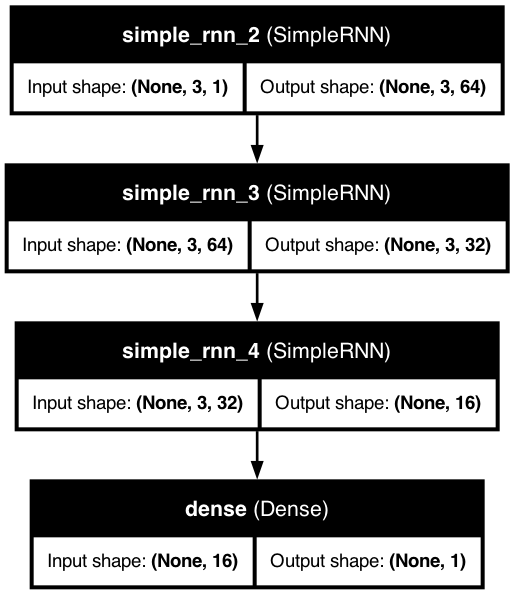

In [25]:
plot_model(
    modelo_2,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96
)

### <span style = 'color: green'>***2.6.2.***</span> Entrenamiento del modelo

In [26]:
#
# Early stopping

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
)
# Parámetros para la optimización del modelo
modelo_2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error', ], 
)

#
# Entrenamiento del modelo
historia_2 = modelo_2.fit(
    X_entr,
    y_entr,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[callback],
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0882 - mean_absolute_error: 0.2333 - mean_squared_error: 0.0882  
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0066 - mean_absolute_error: 0.0621 - mean_squared_error: 0.0066
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - mean_absolute_error: 0.0482 - mean_squared_error: 0.0034
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0014 - mean_absolute_error: 0.0296 - mean_squared_error: 0.0014
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.6098e-04 - mean_absolute_error: 0.0224 - mean_squared_error: 8.6098e-04
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.4271e-04 - mean_absolute_error: 0.0200 - mean_squared_error: 7.4271e-04
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3141e-04 - mean_absolute_error: 0.0156 - mean_squared_error: 4.3141e-04
Epoch 8/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.8314e-04 - mean_absolute_error: 0.0185

/Users/scuartasr/Documents/Maestría/aprenmaq/entreg2/.venv/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error
  current = self.get_monitor_value(logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.7122e-04 - mean_absolute_error: 0.0184 - mean_squared_error: 5.7122e-04
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6678e-04 - mean_absolute_error: 0.0180 - mean_squared_error: 5.6678e-04
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8104e-04 - mean_absolute_error: 0.0145 - mean_squared_error: 3.8104e-04
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8510e-04 - mean_absolute_error: 0.0152 - mean_squared_error: 3.8510e-04
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.1758e-04 - mean_absolute_error: 0.0159 - mean_squared_error: 4.1758e-04
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1019e-04 - mean_absolute_error: 0.0150 - mean_squared_error: 4.1019e-04
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6064e-04 - mean_absolute_error: 0.0158 - mean_squared_error: 4.6064e-04
Epoch 15/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.2482e-04 - mea

### <span style = 'color: green'>***2.6.3.***</span> Predicciones con el modelo

In [27]:
#
# Métricas del modelo
metricas_modelo(modelo_2, X_entr, X_out, y_entr, y_out)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
>>> MÉTRICAS DEL MODELO <<<
 
DATOS DE ENTRENAMIENTO:

MSE: 3.3274

RMSE: 1.8241

MAE: 1.2827

MAPE: 0.0125

R2: 0.9962
 
DATOS DE VALIDACIÓN:

MSE: 9.1903

RMSE: 3.0316

MAE: 2.7284

MAPE: 0.0155

R2: 0.0101


### <span style = 'color: green'>***2.6.4.***</span> Visualización del resultado

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


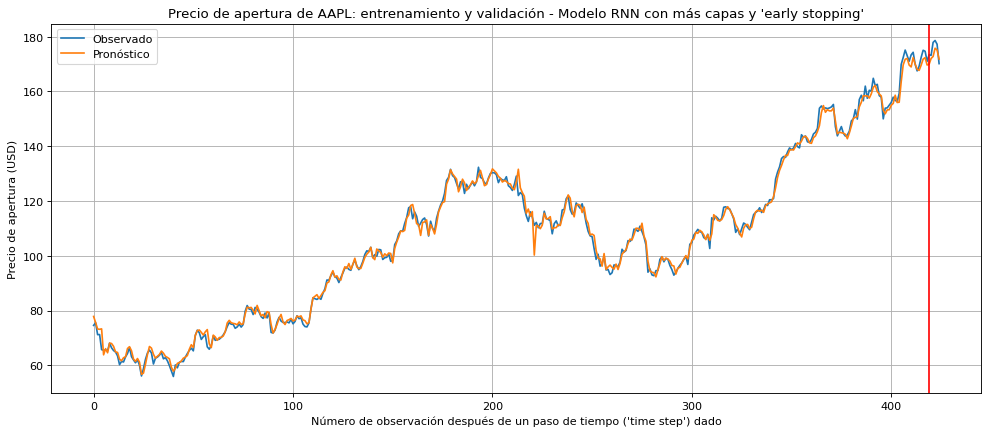

In [28]:
#
# Pronósticos en términos de la escala real de la acción
y_entr_inv = scaler.inverse_transform(y_entr)
y_out_inv = scaler.inverse_transform(y_out)
y_entr_pred_inv = scaler.inverse_transform(modelo_2.predict(X_entr))
y_out_pred_inv = scaler.inverse_transform(modelo_2.predict(X_out))

plot_result(
    y_entr_inv,
    y_out_inv,
    y_entr_pred_inv,
    y_out_pred_inv,
    'Modelo RNN con más capas y \'early stopping\'',
)

<span style = 'color: cyan'>***Comentarios***</span>

En este caso hay una mejora notable en el desempeño del modelo respecto a la versión de RNN simple, ya que durante el periodo de entrenamiento hay un ajuste muy preciso de los datos, que se refleja en un MAPE del 1.25 \%. En el caso del conjunto de validación, esta métrica asciente a un 1.55 \%. En este orden de ideas, se puede pensar que esta serie de tiempo ofrece valores adecuados. Vale la pena notar que el modelo está subestimando el precio de apertura de la acción de Apple en la bolsa, lo cual es un detalle no menor de cara al uso del modelo.

## <span style = 'color: cyan'>***2.7.***</span> Segunda estructura de prueba

### <span style = 'color: green'>***2.7.1.***</span> Configuración del modelo

Ahora, se apelará a una estructura que, conservando la estructura del modelo anterior (2.6), considere ***LSTM***. Se continuará usando *early stopping*.

In [29]:
#
# Configuración del modelo

modelo_3 = Sequential()

modelo_3.add(LSTM(
        64,
        input_shape=(time_steps, 1),
        activation='tanh',
        return_sequences=True, 
    )
)

modelo_3.add(
    LSTM(
        32,
        activation='tanh',
        return_sequences=True, 
    )
)

modelo_3.add(
    LSTM(
        16,
        activation='tanh',
        return_sequences=False, 
    )
)

modelo_3.add(
    Dense(1, activation='linear')
)


/Users/scuartasr/Documents/Maestría/aprenmaq/entreg2/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
modelo_3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 3, 64)          │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 3, 32)          │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,465 (126.82 KB)

 Trainable params: 32,465 (126.82 KB)

 Non-trainable params: 0 (0.00 B)

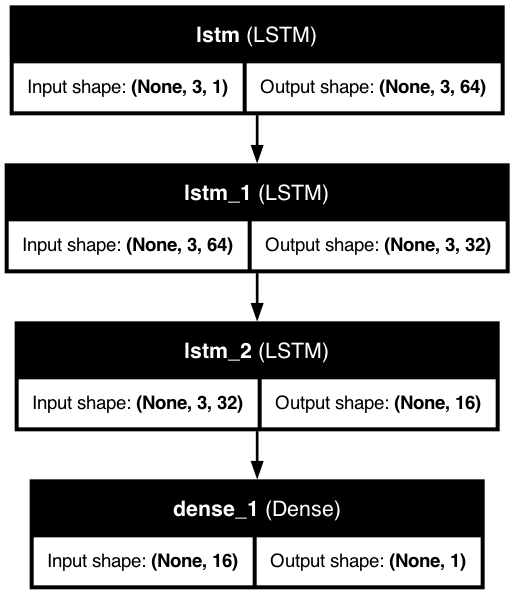

In [31]:
plot_model(
    modelo_3,
    show_shapes=True,
    show_layer_names=True,
    expand_nested=False,
    dpi=96
)

### <span style = 'color: green'>***2.7.2.***</span> Entrenamiento del modelo

In [32]:
#
# Early stopping

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
)
# Parámetros para la optimización del modelo
modelo_3.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error', 'mean_squared_error', ], 
)

#
# Entrenamiento del modelo
historia_2 = modelo_3.fit(
    X_entr,
    y_entr,
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[callback],
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2542 - mean_absolute_error: 0.4314 - mean_squared_error: 0.2542   
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1207 - mean_absolute_error: 0.2788 - mean_squared_error: 0.1207 
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0292 - mean_absolute_error: 0.1406 - mean_squared_error: 0.0292 
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215 - mean_absolute_error: 0.1216 - mean_squared_error: 0.0215
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0124 - mean_absolute_error: 0.0878 - mean_squared_error: 0.0124
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0071 - mean_absolute_error: 0.0670 - mean_squared_error: 0.0071 
Epoch 7/100
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0030 - mean_absolute_error: 0.0416 - mean_squared_error: 0.0030

/Users/scuartasr/Documents/Maestría/aprenmaq/entreg2/.venv/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error
  current = self.get_monitor_value(logs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - mean_absolute_error: 0.0405 - mean_squared_error: 0.0029
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0342 - mean_squared_error: 0.0016
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0016 - mean_absolute_error: 0.0315 - mean_squared_error: 0.0016
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - mean_absolute_error: 0.0278 - mean_squared_error: 0.0013        
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0283 - mean_squared_error: 0.0011
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - mean_absolute_error: 0.0250 - mean_squared_error: 0.0010 
Epoch 13/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0011 - mean_absolute_error: 0.0268 - mean_squared_error: 0.0011
Epoch 14/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.8728e-04 - mean_absolute_error: 0.0236 - mean_squared_error: 8

### <span style = 'color: green'>***2.7.3.***</span> Predicciones con el modelo

In [33]:
#
# Métricas del modelo
metricas_modelo(modelo_3, X_entr, X_out, y_entr, y_out)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>>> MÉTRICAS DEL MODELO <<<
 
DATOS DE ENTRENAMIENTO:

MSE: 5.1890

RMSE: 2.2779

MAE: 1.7054

MAPE: 0.0168

R2: 0.9941
 
DATOS DE VALIDACIÓN:

MSE: 12.4344

RMSE: 3.5262

MAE: 3.1575

MAPE: 0.0180

R2: -0.3393


### <span style = 'color: green'>***2.7.4.***</span> Visualización del resultado

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


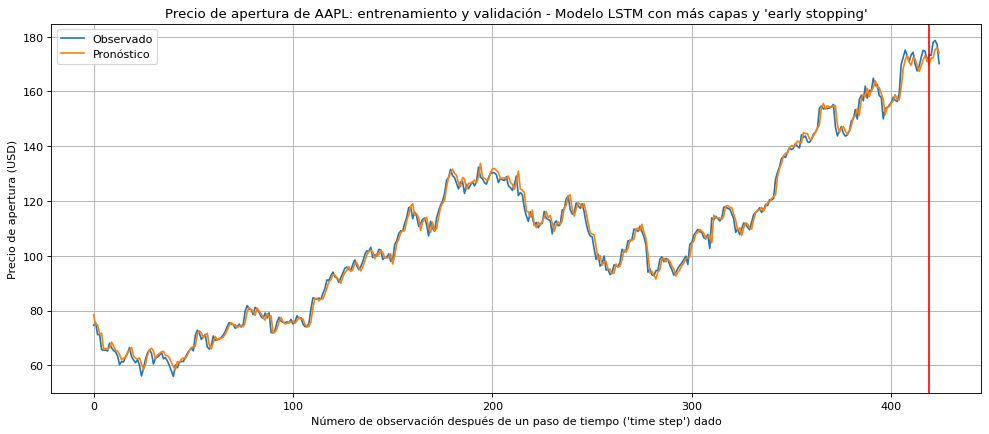

In [34]:
#
# Pronósticos en términos de la escala real de la acción
y_entr_inv = scaler.inverse_transform(y_entr)
y_out_inv = scaler.inverse_transform(y_out)
y_entr_pred_inv = scaler.inverse_transform(modelo_3.predict(X_entr))
y_out_pred_inv = scaler.inverse_transform(modelo_3.predict(X_out))

plot_result(
    y_entr_inv,
    y_out_inv,
    y_entr_pred_inv,
    y_out_pred_inv,
    'Modelo LSTM con más capas y \'early stopping\'',
)

<span style = 'color: cyan'>***Comentarios***</span>

Esta propuesta resulta siendo la mejor de todas en términos del ajuste y la generalización del modelo. Se tiene que en el conjunto de entrenamiento se obtiene un MAPE del 1.68 \%, además, de acuerdo con el MAE, el modelo se equivoca en promedio en USD 1.70 en la predicción del precio de apertura de la acción de Apple durante el período de entrenamiento. En el caso del conjunto de validación, se obtiene un MAPE del 1.80 \% y un error en la predicción promedio de USD 3.16. Además, nótese que en este caso ya no se da una sobreestimación del precio de la acción en entrenamiento, sino de una subestimación.

## <span style = 'color: cyan'>***3.***</span> **Discusión**

En la siguiente tabla se presenta una tabla que condensa el MAE y el MAPE conseguido por cada uno de los tres modelos ensayados para este marco de datos:

| Modelo           | MAE entr.    | MAPE entr. | MAE valid.   | MAPE valid. |
|------------------|--------------|------------|--------------|-------------|
| RNN simple       | USD 4.54     | 4.13 %     | USD 23.54    | 13.43 %     |
| **RNN complejo** | **USD 1.28** | **1.25 %** | **USD 2.72** | **1.55 %**  |
| LSTM complejo    | USD 1.70     | 1.68 %     | USD 3.16     | 1.80 %      |

Sin lugar a dudas, el modelo de **RNN simple** que sigue la arquitectura definida en el ejemplo de clase presenta un desempeño muy pobre, ya que se puede equivocar en más de USD 4 dólares por acción en el conjunto de entrenamiento y hasta más de USD 23 dólares por acción en el de validación. Esto, además, evidencia un sobreajuste importante el modelo, lo cual lo hace inadeucado para su uso en contextos productivos.

Por otra parte, se tiene que tanto el modelo de **RNN complejo** como el de **LSTM complejo**, que tienen ambos la misma configuración pero difieren en el uso de RNN o LSTM como lo indican sus nombres, obtienen muy buenas métricas, con errores de menos de dos dólares tanto en entrenamiento como en validación. Esto evidencia un buen ajuste del modelo y una capacidad adecuada de **generalización**. Es importante anotar que, **en diferentes ejecuciones, puede ser mejor una arquitectura u otra,** por lo que se puede concluir que **ambas son compotentes** para afrontar problemas de esta naturaleza.